In [1]:
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd

import rubin_sim.maf as maf
import rubin_scheduler.utils as rsUtils
from rubin_scheduler.data.data_sets import get_baseline

from mjdinds_functions import radec_to_mjd, MJD_to_inds_magfunc

# Demonstrations

## Using radec_to_mjd() to convert (ra, dec) to multiband MJDs

#### NOTE: This maf methodology is from an outdated version--incorporate your own code regarding package imports, but implementatino in functions should be pretty similar

In [ ]:
import rubin_sim.maf as maf
import rubin_scheduler.utils as rsUtils
from rubin_scheduler.data.data_sets import get_baseline

# <---- If intending to run using slurm with subjob index as `subjob_index` ----> # If not, skip to next header comment

# Import argparse to convert slurm input -subjob_index into variable `subjob_index`
import argparse
parser = argparse.ArgumentParser(description='LSST simulations')
parser.add_argument('-subjob_index', required=True, type=int, help='Job number from slurm array')
args = parser.parse_args()
subjob_index = args.subjob_index

# Define RA, DEC arrays for given subjob_index:
if subjob_index == 0:
    RAs = np.arange(0, 45, 1.5)
    DECs = np.arange(-90, -45, 1.5)
    pass
elif subjob_index == 1:
    RAs = np.arange(45, 90, 1.5)
    DECs = np.arange(-90, -45, 1.5)
    pass

# So on and so forth... you could also make some function to map `subjob_index` to two variables which 
# comprehensively generate different RA, DEC arrays - I just did it the long way.



# <---- If intending to run on-the-spot ----> #
# NOTE: `radec_to_mjd` will be updated in the future to process lists of (ra, dec) pairs into several multiband MJD simulations.

RAs = np.arange(0, 45, 1.5)
DECs = np.arange(-90, -45, 1.5)

mjds = []
sig5s = []
fulls = []
radec = []

bands = ['g', 'r', 'i'] # If you only want one band, leave in list format (e.g. bands=['g'])

for i, ra in enumerate(RAs):
    for j, dec in enumerate(DECs):
        radec.append([ra, dec])
        q = radec_to_mjd(ra, dec, bands, vet_lim=0.)
        full = list(q.values()) # If you have three bands, this will be a 3-list ; each element of this array corresponds to one of 
        # your bands, so each element will be a 2-list ; the first element of which is the mjds and the second element of which is 
        # the 5-sigma depths. Sorry if that's confusing
        fulls.append(full)
        pass
    pass

dirname = 'maf_out/'
np.save(dirname+'mjd_sig5', np.array(fulls, dtype=object)) # note, you would add str(subjob_index) to filename if 
# you intend to run in parallel

np.savetxt(dirname+'lsst_radec.txt', radec) # note, you would add str(subjob_index) to filename if you intend to run in parallel

# This will create a textfile of all your (ra, dec) coordinates and an N-list of your mjds and 5-sigma depths for each band (where
# N corresponds to the amount of (ra, dec) pairs you have)

# Each element of the N-list will be a n-list where n is the number of bands. Each element of this n-list, corresponding to a different
# band, will be a 2-list. The first element of this 2-list will be the array of MJDs and the second element will be the array of
# 5-sigma depths! This format makes for easy combination with the other functions defined here

## ** MJD_to_inds_magfunc() to create masking arrays AND a photometric uncertainty calculator **

#### Grab array of MJDs and 5-sigma depths: Using rubin_sims to store mjds and 5-sigma depths in `.npy` files

In [300]:
fn = 'mjd_sig5_1.npy'
x = np.load(fn, allow_pickle=True)

In [304]:
key = 4 # Random key to grab one of the N simulations
dict_ = dict(zip(bands, x[key])) # Reshaping `MJDs` and `sig5s` to appropriate format

time, sample_dict = MJD_to_inds_magfunc(dict_, bands=bands, nondets=True, gauss=False)

# IGNORE:
# MJDs = [x[key, 0, 0], x[key, 1, 0], x[key, 2, 0]] # The first key index selects one of the N simuations. The second index corresponds
# # to the band of the generate MJDs, and the final index corresponds to whether we are grabbing the MJDs or the 5-sigma depths
# sig5s = [x[key, 0, 1], x[key, 1, 1], x[key, 2, 1]]

#### !! Use `time` array from MJD_to_inds_magfunc() output to SIMULATE YOUR LIGHT CURVE. It is daily-cadenced and spans all observations in all bands

In [309]:
y = 22 - 2*np.sin(2*np.pi/1000 * (time))

inds_g = sample_dict['g'][0][0]
inds_r = sample_dict['r'][0][0]
inds_i = sample_dict['i'][0][0]

magfunc_g = sample_dict['g'][1][0]
magfunc_r = sample_dict['r'][1][0]
magfunc_i = sample_dict['i'][1][0]

y_g, yerr_g = magfunc_g(y[inds_g]) # `magfunc` outputs photometric uncertainties AND new magnitudes to 1) account for non-detections
# and 2) automatically mask with `inds` array.
y_r, yerr_r = magfunc_r(y[inds_r])
y_i, yerr_i = magfunc_i(y[inds_i])

Text(0, 0.5, 'Magnitudes')

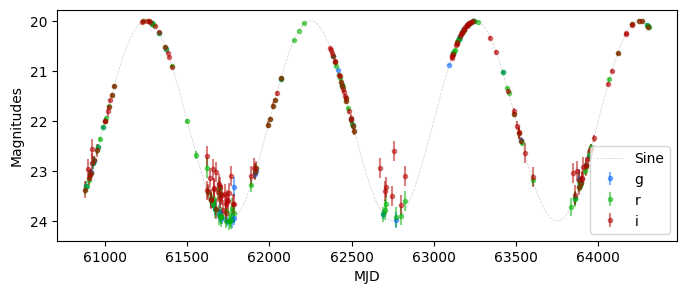

In [310]:
f, ax = plt.subplots(figsize=(8, 3))
ax.errorbar(time[inds_g], y_g, yerr_g, ls='None', ms=3, marker='o', color=(0, .4, 1, .5), label='g')
ax.errorbar(time[inds_r], y_r, yerr_r, ls='None', ms=3, marker='o', color=(0, .7, 0, .5), label='r')
ax.errorbar(time[inds_i], y_i, yerr_i, ls='None', ms=3, marker='o', color=(.7, 0, 0, .5), label='i')
ax.plot(time, y, ls='--', color=(0, 0, 0, .2), lw=.5, label='Sine')

ax.invert_yaxis()
plt.legend()
ax.set_xlabel('MJD')
ax.set_ylabel('Magnitudes')

In [ ]:
# Will demonstrate how to do this with ezTao simulations at some point... IT BOILS DOWN TO USING THE FUNCTION-OUTPUT `time` TO SIMULATE
# YOUR DATA SO YOU CAN TRIVIALLY APPLY MASKING ARRAYS `inds_g`, `inds_r`, ... TO YOUR SIMULATIONS!